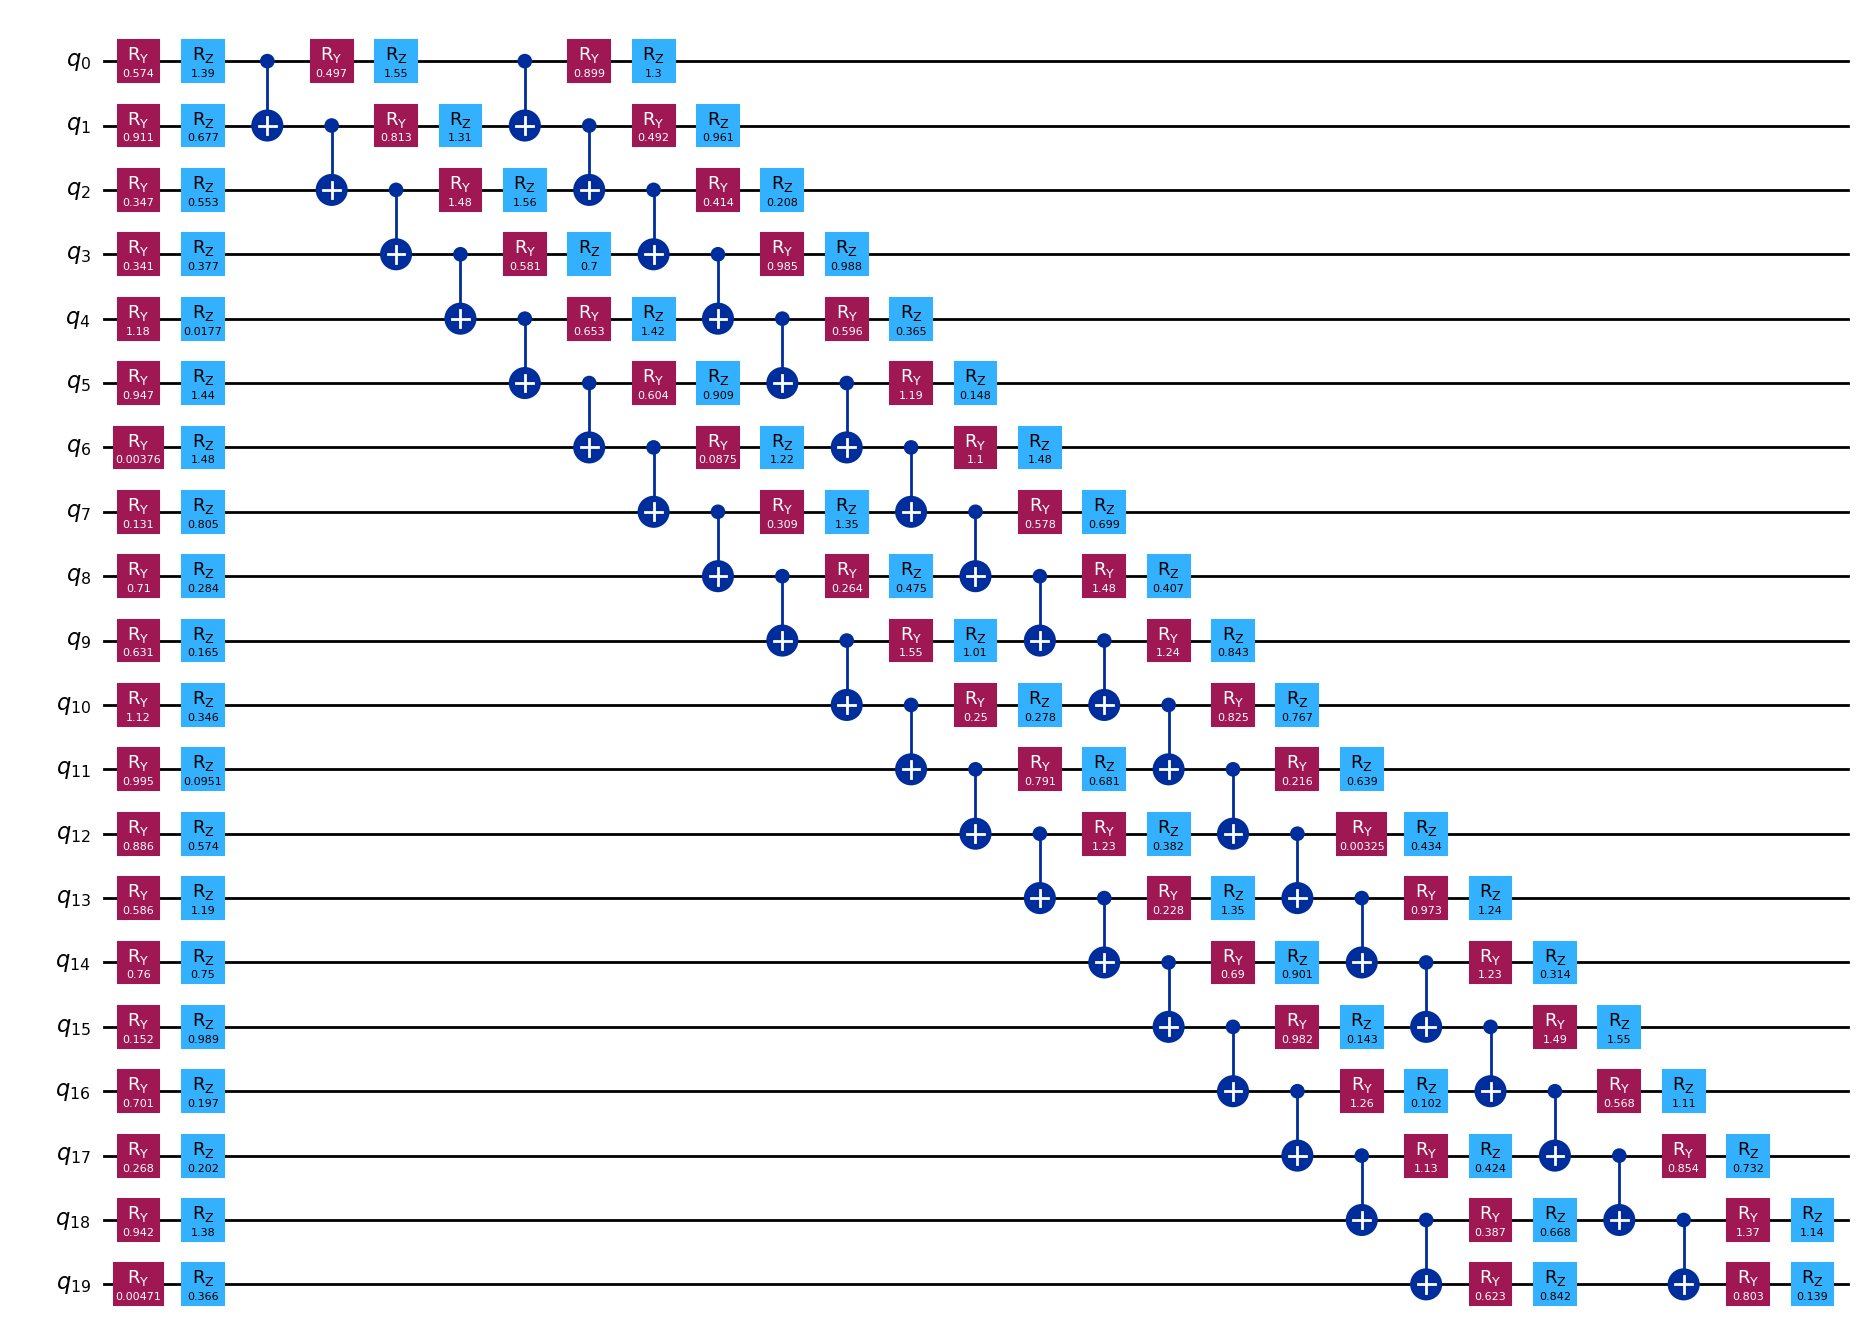

In [21]:
import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal

circuit = TwoLocal(20, ["ry", "rz"], "cx", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)
# circuit.measure_all()

# circuit = random_circuit(7, 15, max_operands=2, seed=1242)
# observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])


circuit.draw("mpl", fold=-1)

Found solution using 8 cuts with a sampling overhead of 43046721.0.
Gate Cut at circuit instruction index 25
Gate Cut at circuit instruction index 36
Gate Cut at circuit instruction index 57
Gate Cut at circuit instruction index 68
Gate Cut at circuit instruction index 89
Gate Cut at circuit instruction index 100
Gate Cut at circuit instruction index 121
Gate Cut at circuit instruction index 132


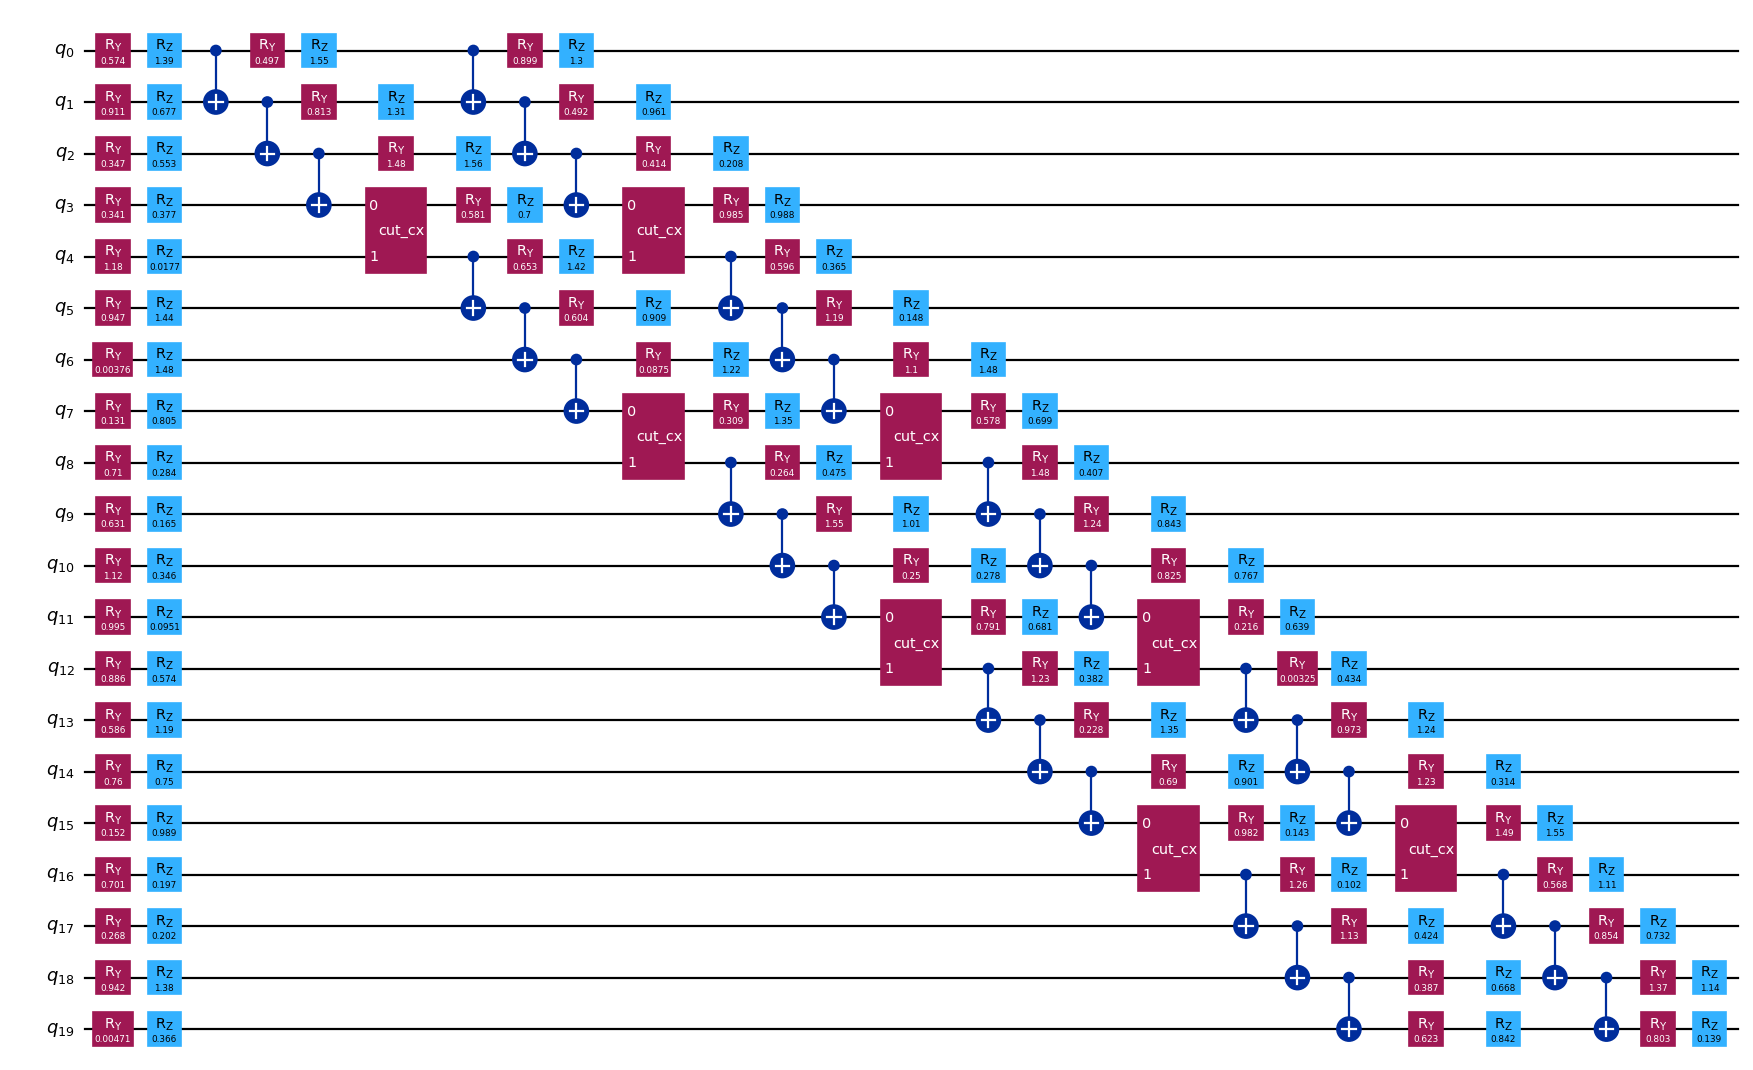

In [22]:
from circuit_knitting.cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

In [ ]:
from qtpu.circuit import circuit_to_hybrid_tn


tn = circuit_to_hybrid_tn(qpd_circuit)
from qtpu.contract2 import contract

contracted_tn = contract(tn)

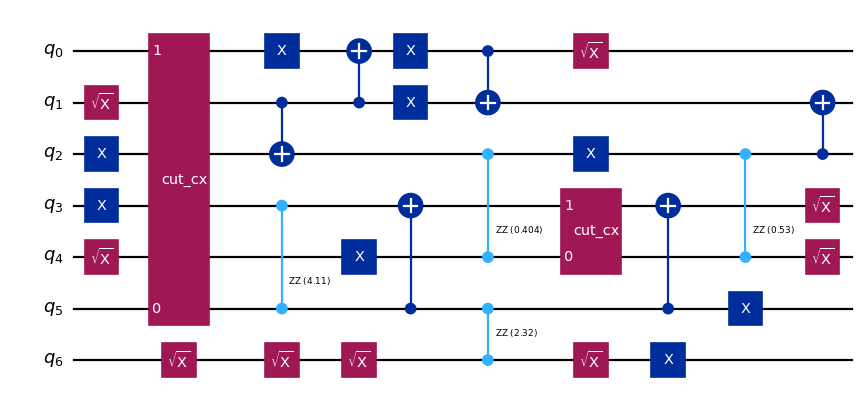

In [3]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [4]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

Sampling overhead: 81.0


In [5]:
subobservables

{0: PauliList(['IIII', 'IIII', 'IIIZ']), 1: PauliList(['ZII', 'IIZ', 'III'])}

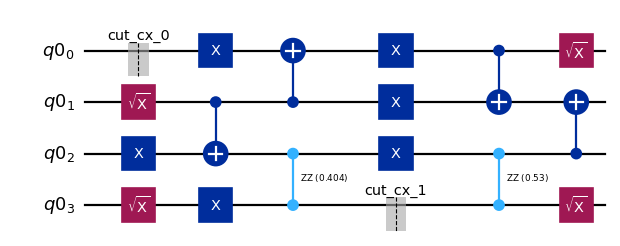

In [6]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

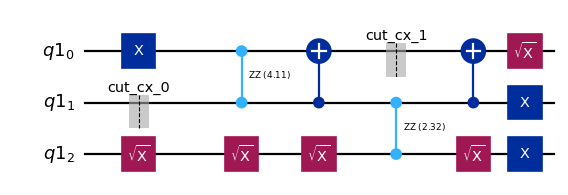

In [7]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

In [8]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

72 total subexperiments to run on backend.
